In [1]:
import pandas as pd

import numpy as np
import tensorflow as tf
import networkx as nx

wd = '/Users/ewenwang/Documents/practice_data/conversion_rate/'
data = 'round1_ijcai_18_train_20180301.txt'

target = 'is_trade'
features = ['user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 
            'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 
            'shop_review_num_level', 'shop_review_positive_rate', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']

sourcetarget = ['user_id', 'item_id']

nodecol = 'user_id'

In [2]:
data = pd.read_csv(wd+data, sep=' ')

In [3]:
data = data.head(2000)

In [4]:
edgelist = pd.DataFrame()
edgelist['user_id'] = data.user_id
edgelist['item_id'] = data.item_id

df_target = data[sourcetarget+[target]].groupby(sourcetarget ,as_index=False).sum()
df_features = data[sourcetarget+features].groupby(sourcetarget, as_index=False).mean()

df = df_target.merge(df_features, how='left', on=sourcetarget)

In [5]:
df.head()

,user_id,item_id,is_trade,user_gender_id,user_age_level,user_occupation_id,user_star_level,item_price_level,item_sales_level,item_collected_level,item_pv_level,shop_review_num_level,shop_review_positive_rate,shop_score_service,shop_score_delivery,shop_score_description
0,8078017541935668,4215883534709645310,0,0,1002,2005,3006,7,11,13,19,21,0.99704,0.979661,0.979589,0.975442
1,8078017541935668,8824610546121211352,0,0,1002,2005,3006,7,11,12,19,21,0.99704,0.979661,0.979589,0.975442
2,18242482054767926,5323767931396822716,0,0,1003,2005,3004,7,13,14,19,16,1.00000,0.967400,0.967237,0.983510
3,23297531048455633,4215883534709645310,0,0,1003,2002,3006,7,11,13,19,21,0.99704,0.979661,0.979589,0.975442
4,23297531048455633,8824610546121211352,0,0,1003,2002,3006,7,11,12,19,21,0.99704,0.979661,0.979589,0.975442


In [39]:
def onehot_encoder(target_ls):
    classes = set(target_ls)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    target_onehot = np.array(list(map(classes_dict.get, target_ls)), dtype=np.int32)
    return target_onehot, [*classes]

def adjacency_normalizer(adj):
    adj = adj + np.eye(adj.shape[0])
    d = np.diagflat(np.power(np.array(adj.sum(1)), -1))
    a_norm = d.dot(adj)
    return a_norm

In [40]:
g = nx.from_pandas_edgelist(edgelist, 
                            source=edgelist.columns[0], 
                            target=edgelist.columns[1], 
                            create_using=nx.MultiGraph())

a = adjacency_normalizer(nx.to_numpy_matrix(g))

In [41]:
df_node = pd.DataFrame({nodecol: g.nodes()})
df_node = pd.merge(df_node, df, how='left', on=nodecol, sort=False)

df_node = df_node[np.isfinite(df_node[target])]

df_node = df_node.head(a.shape[0])    # trick!

x = df_node[features]
y, classes = onehot_encoder(list(df_node[target]))

In [42]:
df_node.shape

(1747, 16)

### training

In [74]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [75]:
n_nodes = g.number_of_nodes()
n_features = len(features)
n_classes = len(classes)

In [79]:
loss_ls = []
predictions = None

learning_rate = 0.001
n_epochs = 1000
verbose = 50
early_stopping = 200

In [85]:
def graph_convolution(a, x, w, b):
    with tf.name_scope('gcn_layer'):
        kernel = tf.add(tf.matmul(a, tf.matmul(x, w)), b)
        return tf.nn.tanh(kernel)

n_dense1 = 512
n_dense2 = 256
n_dense3 = 128
n_dense4 = 64
n_dense5 = 16

tf.reset_default_graph()
tf.set_random_seed(1)

adjacency = tf.placeholder(tf.float32, shape=(n_nodes, n_nodes), name='adjacency')
feature = tf.placeholder(tf.float32, shape=(n_nodes, n_features), name='feature')
label = tf.placeholder(tf.float32, shape=(n_nodes, n_classes), name='label')

with tf.name_scope('gcn1'):
    weights1 = tf.Variable(tf.random_normal([n_features, n_features]), name='weights1')
    bais1 = tf.Variable(tf.random_normal([n_nodes, n_features]), name='bais1')
    gcn1 = graph_convolution(a=adjacency, x=feature, w=weights1, b=bais1)

with tf.name_scope('gcn2'):
    weights2 = tf.Variable(tf.random_normal([n_features, n_dense1]), name='weights2')
    bais2 = tf.Variable(tf.random_normal([n_nodes, n_dense1]), name='bais2')
    gcn2 = graph_convolution(a=adjacency, x=gcn1, w=weights2, b=bais2)

with tf.contrib.framework.arg_scope([tf.contrib.layers.fully_connected], activation_fn=tf.nn.elu,):
    dense1 = tf.contrib.layers.fully_connected(inputs=gcn2, num_outputs=n_dense2, scope='dense1')
    dense2 = tf.contrib.layers.fully_connected(inputs=dense1, num_outputs=n_dense3, scope='dense2')
    dense3 = tf.contrib.layers.fully_connected(inputs=dense2, num_outputs=n_dense4, scope='dense3')
    dense4 = tf.contrib.layers.fully_connected(inputs=dense3, num_outputs=n_dense5, scope='dense4')
    dense5 = tf.contrib.layers.fully_connected(inputs=dense4, num_outputs=n_classes, scope='dense5')

with tf.name_scope('output'):
    output = tf.nn.softmax(logits=dense5, axis=-1, name='output')

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=label))

training_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [86]:
init = tf.global_variables_initializer()

loss_summary = tf.summary.scalar('loss', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

best_loss = 999
stopping_step = 0

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        training_op.run(feed_dict={adjacency: a, feature: x, label: y})
        if verbose <= 0:
            pass
        elif epoch % verbose == 0:
            cost = loss.eval(feed_dict={adjacency: a, feature: x, label: y})
            loss_ls.append(cost)
            print(epoch, '\tloss: %.6f' %cost)
            summary_str = loss_summary.eval(feed_dict={adjacency: a, feature: x, label: y})
            file_writer.add_summary(summary_str, epoch)
        
        if best_loss > cost:
            stopping_step = 0
            best_loss = cost
        else:
            stopping_step += 1
        if stopping_step >= early_stopping:
            print('early stopping triggered at epoch: %d with best loss: %.6f.' % (epoch, best_loss))
            break
    predictions = output.eval(feed_dict={adjacency: a, feature: x, label: y})
file_writer.close()

0 	loss: 0.339588
50 	loss: 0.319562
100 	loss: 0.319561
150 	loss: 0.319560
200 	loss: 0.319560
250 	loss: 0.319560
300 	loss: 0.319560
350 	loss: 0.319559
400 	loss: 0.319559
450 	loss: 0.319559
500 	loss: 0.319559
550 	loss: 0.319559
600 	loss: 0.319559
650 	loss: 0.319559
700 	loss: 0.319559
750 	loss: 0.319559
800 	loss: 0.319559
850 	loss: 0.319559
900 	loss: 0.319559
950 	loss: 0.319559
early stopping triggered at epoch: 950 with best loss: 0.319559.


In [87]:
pred = pd.DataFrame(predictions, columns=classes)
pred.head()

,0.0,1.0
0,0.999999,5.813629e-07
1,0.999999,6.301595e-07
2,0.999999,6.157786e-07
3,0.999999,8.482277e-07
4,0.999999,9.131590e-07


In [51]:
from Report import Visual

In [88]:
vis = Visual(df_node[target], pred[pred.columns[1]])


Model Report
Recall metric in the testing dataset:  0.0
             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00      1736
        1.0       0.00      0.00      0.00        11

avg / total       0.99      0.99      0.99      1747

Confusion matrix, without normalization


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


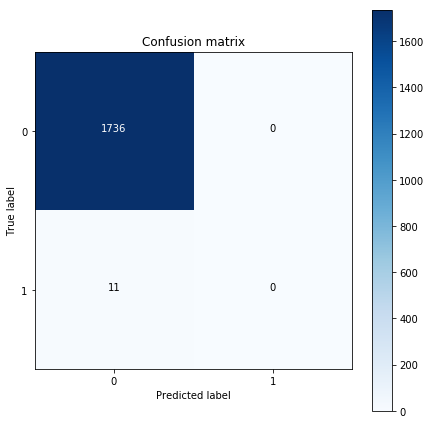

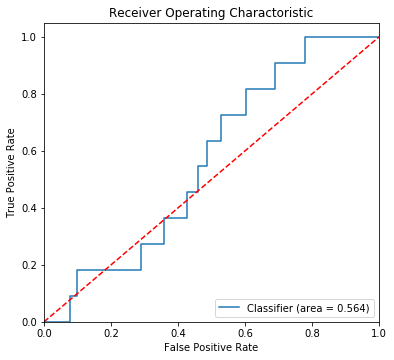


Model Report
Average Precision: 0.008


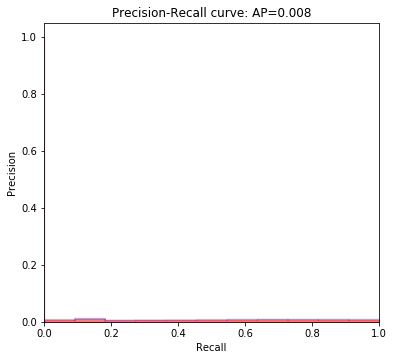

In [89]:
vis.CM()
vis.ROC()
vis.PR()